# Problem Definition

### Rents in Stuttgart were rising a lot over the last years. It is therefore often difficult to find an appartment that fits your needs whithin your given budget limit. 

So with this Project we can help people to see, in which districts of Stuttgart they should start looking:
- If the rent demanded by the owner is too high for the spesific District
- Which district is the cheapest district
- Which area is the best regarding the venues

This project helps people who want to move to Stuttgart or people who already live in Stuttgart but are looking for a new apartment.


**Data:**
The data on apartments (size, number of rooms, address, and price) is collected by scraping a local website with apartment listings (Immoscout24.de). For the coordinates of the districts we use geopy and take the Data from the official website of the city stuttgart (https://www.stuttgart.de/medien/ibs/KLGL_DXF.zipTo) that I labeld and converted my self. To Collect the Venues I use Foursquare. After the Data collection process we run k-means clustering to cluster the districts into residential and commercial areas and visualize the data on a choropleth map.


In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import requests
from requests import get
from bs4 import BeautifulSoup
import re
import json
from pandas.io.json import json_normalize
import urllib.request as urllib2
import random
from random import choice
import time
from time import sleep
#!pip install geopy
from geopy.geocoders import Nominatim 
from geopy.distance import great_circle
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#!pip install folium
import folium 
from folium import plugins
import seaborn as sns
from sklearn.cluster import KMeans
from urllib.request import urlopen
import json




print('Libraries imported.')

Libraries imported.


In [2]:
def urlquery(url):
    
    try:
        sleeptime = float(random.randint(1,6))/5
        time.sleep(sleeptime)

        agents = ['Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1309.0 Safari/537.17',
        'Mozilla/5.0 (compatible; MSIE 10.6; Windows NT 6.1; Trident/5.0; InfoPath.2; SLCC1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 2.0.50727) 3gpp-gba UNTRUSTED/1.0',
        'Opera/12.80 (Windows NT 5.1; U; en) Presto/2.10.289 Version/12.02',
        'Mozilla/4.0 (compatible; MSIE 5.5; Windows NT)',
        'Mozilla/3.0',
        'Mozilla/5.0 (iPhone; U; CPU like Mac OS X; en) AppleWebKit/420+ (KHTML, like Gecko) Version/3.0 Mobile/1A543a Safari/419.3',
        'Mozilla/5.0 (Linux; U; Android 0.5; en-us) AppleWebKit/522+ (KHTML, like Gecko) Safari/419.3',
        'Opera/9.00 (Windows NT 5.1; U; en)']

        agent = choice(agents)
        opener = urllib2.build_opener()
        opener.addheaders = [('User-agent', agent)]

        html = opener.open(url).read()
        time.sleep(sleeptime)
        
        return html

    except Exception as e:
        print('Something went wrong with Crawling:\n%s' % e)

In [3]:
def immoscout24parser(url):
    
    ''' Parser holt aus Immoscout24.de Suchergebnisseiten die Immobilien '''
    
    try:
        soup = BeautifulSoup(urlquery(url), 'html.parser')
        scripts = soup.findAll('script')
        for script in scripts:
            #print script.text.strip()
            if 'IS24.resultList' in script.text.strip():
                s = script.string.split('\n')
                for line in s:
                    #print('\n\n\'%s\'' % line)
                    if line.strip().startswith('resultListModel'):
                        resultListModel = line.strip('resultListModel: ')
                        immo_json = json.loads(resultListModel[:-1])

                        searchResponseModel = immo_json[u'searchResponseModel']
                        resultlist_json = searchResponseModel[u'resultlist.resultlist']
                        
                        return resultlist_json

    except Exception as e:
        print("Fehler in immoscout24 parser: %s" % e)

In [4]:
immos = {}

# See immoscout24.de URL in Browser!
b = 'baden-wuerttemberg' # Bundesland
s = 'stuttgart' # Stadt
k = 'Wohnung' # Wohnung oder Haus
w = 'Miete' # Miete oder Kauf

page = 0
print('Suche %s / %s' % (k, w))

while True:
    page+=1
   # url = 'http://www.immobilienscout24.de/Suche/S-T/P-%s/%s-%s/%s/%s?pagerReporting=true' % (page, k, w, b, s)
    url = 'https://www.immobilienscout24.de/Suche/de/%s/%s/wohnung-mieten?pagenumber=%s' % (b, s, page)
   
    
    # Because of some timeout or immoscout24.de errors,
    # we try until it works \o/
    resultlist_json = None
    while resultlist_json is None:
        try:
            resultlist_json = immoscout24parser(url)
            numberOfPages = int(resultlist_json[u'paging'][u'numberOfPages'])
            pageNumber = int(resultlist_json[u'paging'][u'pageNumber'])
        except:
            pass

    if page>numberOfPages:
        break

    # Get the data
    for resultlistEntry in resultlist_json['resultlistEntries'][0][u'resultlistEntry']:
        realEstate_json = resultlistEntry[u'resultlist.realEstate']
        
        realEstate = {}

        realEstate[u'Miete/Kauf'] = w
        realEstate[u'Haus/Wohnung'] = k

        realEstate['address'] = realEstate_json['address']['description']['text']
        realEstate['city'] = realEstate_json['address']['city']
        realEstate['postcode'] = realEstate_json['address']['postcode']
        realEstate['quarter'] = realEstate_json['address']['quarter']
        try:
            realEstate['lat'] = realEstate_json['address'][u'wgs84Coordinate']['latitude']
            realEstate['lon'] = realEstate_json['address'][u'wgs84Coordinate']['longitude']
        except:
            realEstate['lat'] = None
            realEstate['lon'] = None
            
        realEstate['title'] = realEstate_json['title']

        realEstate['numberOfRooms'] = realEstate_json['numberOfRooms']
        realEstate['livingSpace'] = realEstate_json['livingSpace']
        
        if k=='Wohnung':
            realEstate['balcony'] = realEstate_json['balcony']
            realEstate['builtInKitchen'] = realEstate_json['builtInKitchen']
            realEstate['garden'] = realEstate_json['garden']
            realEstate['price'] = realEstate_json['price']['value']
            realEstate['privateOffer'] = realEstate_json['privateOffer']
        elif k=='Haus':
            realEstate['isBarrierFree'] = realEstate_json['isBarrierFree']
            realEstate['cellar'] = realEstate_json['cellar']
            realEstate['plotArea'] = realEstate_json['plotArea']
            realEstate['price'] = realEstate_json['price']['value']
            realEstate['privateOffer'] = realEstate_json['privateOffer']
            realEstate['energyPerformanceCertificate'] = realEstate_json['energyPerformanceCertificate']
        
        realEstate['floorplan'] = realEstate_json['floorplan']
        realEstate['from'] = realEstate_json['companyWideCustomerId']
        realEstate['ID'] = realEstate_json[u'@id']
        realEstate['url'] = u'https://www.immobilienscout24.de/expose/%s' % realEstate['ID']

        immos[realEstate['ID']] = realEstate
        
    print('Scrape Page %i/%i (%i Immobilien %s %s gefunden)' % (page, numberOfPages, len(immos), k, w))

Suche Wohnung / Miete
Something went wrong with Crawling:
HTTP Error 405: 
Fehler in immoscout24 parser: object of type 'NoneType' has no len()
Something went wrong with Crawling:
HTTP Error 405: 
Fehler in immoscout24 parser: object of type 'NoneType' has no len()
Something went wrong with Crawling:
HTTP Error 405: 
Fehler in immoscout24 parser: object of type 'NoneType' has no len()
Scrape Page 1/76 (20 Immobilien Wohnung Miete gefunden)
Something went wrong with Crawling:
HTTP Error 405: 
Fehler in immoscout24 parser: object of type 'NoneType' has no len()
Something went wrong with Crawling:
HTTP Error 405: 
Fehler in immoscout24 parser: object of type 'NoneType' has no len()
Scrape Page 2/76 (40 Immobilien Wohnung Miete gefunden)
Scrape Page 3/76 (60 Immobilien Wohnung Miete gefunden)
Scrape Page 4/76 (80 Immobilien Wohnung Miete gefunden)
Scrape Page 5/76 (100 Immobilien Wohnung Miete gefunden)
Something went wrong with Crawling:
HTTP Error 405: 
Fehler in immoscout24 parser: obje

In [5]:
print("Scraped %i Immos" % len(immos))

Scraped 1519 Immos


In [6]:
from datetime import datetime
timestamp = datetime.strftime(datetime.now(), '%Y-%m-%d')

In [7]:
df = pd.DataFrame(immos).T
df.index.name = 'ID'

In [8]:
df.livingSpace[df.livingSpace==0] = None
df['EUR/qm'] = df.price / df.livingSpace

In [9]:
df.sort_values(by='EUR/qm', inplace=True)

In [10]:
len(df)

1519

In [11]:
df.head()

Miete/Kauf Haus/Wohnung                                   address  \
ID                                                                            
128484782      Miete      Wohnung         Metzstraße -, Stöckach, Stuttgart   
128572870      Miete      Wohnung  Waldmeisterweg 18, Gablenberg, Stuttgart   
128229363      Miete      Wohnung       Nagoldstraße 70, Münster, Stuttgart   
122917677      Miete      Wohnung                        Kurpark, Stuttgart   
128088611      Miete      Wohnung             Kneippweg 8, Espan, Stuttgart   

                city postcode        quarter      lat      lon  \
ID                                                               
128484782  Stuttgart    70190            Ost  48.7923  9.20146   
128572870  Stuttgart    70186            Ost   48.772  9.20901   
128229363  Stuttgart    70376        Münster   48.821  9.21732   
122917677  Stuttgart    70372  Bad Cannstatt     None     None   
128088611  Stuttgart    70374  Bad Cannstatt  48.8084  9.23477   

                                                       title numberOfRooms  \
ID                                                                           
128484782  3er WG im Herzen Stuttgarts sucht neue Bewohne...             1   
128572870  Gepflegte, möblierte Studenten-Wohnung zur Mie...             1   
128229363               3-Zimmerwohnung in Stuttgart-Münster             3   
122917677  Gemütliche, teilmöblierte Ein-Zimmer-Dachgesch...             1   
128088611  Einfach großzügig! Wohnen im Dachgeschoss! Ide...             3   

           ... balcony builtInKitchen garden   price privateOffer floorplan  \
ID         ...                                                                
128484782  ...   false           true  false     420        false      true   
128572870  ...   false          false  false     180         true     false   
128229363  ...   false          false  false  597.82        false      true   
122917677  ...   false           true  false     350        false     false   
128088611  ...   false          false  false  826.87        false      true   

                                               from         ID  \
ID                                                               
128484782                               001.5394580  128484782   
128572870  009.4fd52cce-1d2a-4a45-90f4-70d5641acc0e  128572870   
128229363                                001.886776  128229363   
122917677                                001.385688  122917677   
128088611                                001.356090  128088611   

                                                         url   EUR/qm  
ID                                                                     
128484782  https://www.immobilienscout24.de/expose/128484782  6.46154  
128572870  https://www.immobilienscout24.de/expose/128572870  8.57143  
128229363  https://www.immobilienscout24.de/expose/128229363  8.74006  
122917677  https://www.immobilienscout24.de/expose/122917677  8.97436  
128088611  https://www.immobilienscout24.de/expose/128088611  9.15996  

[5 rows x 21 columns]

In [12]:
f = open('%s-%s-%s-%s-%s.csv' % (timestamp, b, s, k, w), 'w')
#f.write('# %s %s from immoscout24.de on %s\n' % (k,w,timestamp))
#df[(df['Haus/Wohnung']==k) & (df['Miete/Kauf']==w)].to_csv(f, encoding='utf-8')
f.close()

In [13]:
#df.to_excel('%s-%s-%s-%s-%s.xlsx' % (timestamp, b, s, k, w))
df

Miete/Kauf Haus/Wohnung                                   address  \
ID                                                                            
128484782      Miete      Wohnung         Metzstraße -, Stöckach, Stuttgart   
128572870      Miete      Wohnung  Waldmeisterweg 18, Gablenberg, Stuttgart   
128229363      Miete      Wohnung       Nagoldstraße 70, Münster, Stuttgart   
122917677      Miete      Wohnung                        Kurpark, Stuttgart   
128088611      Miete      Wohnung             Kneippweg 8, Espan, Stuttgart   
...              ...          ...                                       ...   
128714268      Miete      Wohnung                        Rathaus, Stuttgart   
128714272      Miete      Wohnung                        Rathaus, Stuttgart   
128714360      Miete      Wohnung                        Rathaus, Stuttgart   
128714277      Miete      Wohnung                        Rathaus, Stuttgart   
127937381      Miete      Wohnung      Donzdorferstr. 15, Wangen, Stuttgart   

                city postcode        quarter      lat      lon  \
ID                                                               
128484782  Stuttgart    70190            Ost  48.7923  9.20146   
128572870  Stuttgart    70186            Ost   48.772  9.20901   
128229363  Stuttgart    70376        Münster   48.821  9.21732   
122917677  Stuttgart    70372  Bad Cannstatt     None     None   
128088611  Stuttgart    70374  Bad Cannstatt  48.8084  9.23477   
...              ...      ...            ...      ...      ...   
128714268  Stuttgart    70173          Mitte     None     None   
128714272  Stuttgart    70173          Mitte     None     None   
128714360  Stuttgart    70173          Mitte     None     None   
128714277  Stuttgart    70173          Mitte     None     None   
127937381  Stuttgart    70327         Wangen  48.7731   9.2445   

                                                       title numberOfRooms  \
ID                                                                           
128484782  3er WG im Herzen Stuttgarts sucht neue Bewohne...             1   
128572870  Gepflegte, möblierte Studenten-Wohnung zur Mie...             1   
128229363               3-Zimmerwohnung in Stuttgart-Münster             3   
122917677  Gemütliche, teilmöblierte Ein-Zimmer-Dachgesch...             1   
128088611  Einfach großzügig! Wohnen im Dachgeschoss! Ide...             3   
...                                                      ...           ...   
128714268  MÖBLIERT - TOP LIVING - Modernes Business-Apar...             1   
128714272  MÖBLIERT - TOP LIVING - Modernes Business-Apar...             1   
128714360  MÖBLIERT - VIEL BESSER ALS HOTEL - Modernes Ap...             2   
128714277  MÖBLIERT - VIEL BESSER ALS HOTEL - Modernes Ap...             1   
127937381  Erstbezug nach Sanierung: stilvolle 3 Zimmer-W...             3   

           ... balcony builtInKitchen garden   price privateOffer floorplan  \
ID         ...                                                                
128484782  ...   false           true  false     420        false      true   
128572870  ...   false          false  false     180         true     false   
128229363  ...   false          false  false  597.82        false      true   
122917677  ...   false           true  false     350        false     false   
128088611  ...   false          false  false  826.87        false      true   
...        ...     ...            ...    ...     ...          ...       ...   
128714268  ...   false          false  false    1800        false     false   
128714272  ...   false          false  false    1800        false     false   
128714360  ...   false          false  false    2060        false     false   
128714277  ...    true          false  false    2320        false     false   
127937381  ...   false           true  false   10000         true     false   

                                               from         ID  \
ID            

In [14]:
df = df.drop(['ID', 'Haus/Wohnung', 'Miete/Kauf', 'balcony', 'builtInKitchen', 'floorplan', 'from', 'garden', 'title', 'url', 'lat'], axis=1 )
df = df.reset_index()
df = df.drop(['ID', 'lon'], axis= 1)
df = df.drop(['privateOffer', 'city', 'address'], axis= 1)
df = df.rename(columns={"livingSpace":"Size", "numberOfRooms": "Rooms", "postcode": "PostalCode", "price": "Price", "quarter": "District", "EUR/qm": "Price/m2"})
df = df[['PostalCode', 'District', 'Size', 'Rooms', 'Price', 'Price/m2']]

In [15]:
df.head()

PostalCode       District   Size Rooms   Price Price/m2
0      70190            Ost     65     1     420  6.46154
1      70186            Ost     21     1     180  8.57143
2      70376        Münster   68.4     3  597.82  8.74006
3      70372  Bad Cannstatt     39     1     350  8.97436
4      70374  Bad Cannstatt  90.27     3  826.87  9.15996

# Pre-process & visualization the data

In [16]:
rental_properties = df[['PostalCode', 'District', 'Size', 'Rooms', 'Price', 'Price/m2']]
rental_properties.dtypes

PostalCode    object
District      object
Size          object
Rooms         object
Price         object
Price/m2      object
dtype: object

In [17]:
rental_properties['Price'] = rental_properties['Price'].astype('float')
rental_properties['Price/m2'] = rental_properties['Price/m2'].astype('float')
rental_properties['Size'] = rental_properties['Size'].astype('float')
rental_properties['Rooms'] = rental_properties['Rooms'].astype('float')
rental_properties.dtypes

PostalCode     object
District       object
Size          float64
Rooms         float64
Price         float64
Price/m2      float64
dtype: object

In [18]:
#checking for NaN Values
rental_properties.isnull().sum()

PostalCode    0
District      0
Size          0
Rooms         0
Price         0
Price/m2      0
dtype: int64

In [19]:
rental_properties['Rooms'].value_counts()

2.0    416
3.0    382
1.0    334
4.0    110
2.5     97
3.5     71
1.5     44
4.5     33
5.0     20
5.5      7
6.0      4
7.0      1
Name: Rooms, dtype: int64

**We can visualize the number of apartments per room number and number of apartments in each district**

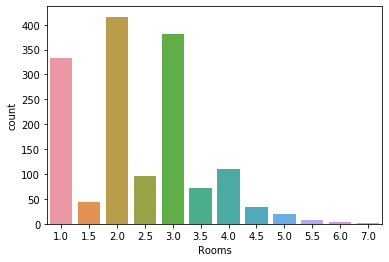

In [20]:
sns.countplot(data=rental_properties, x='Rooms')

In [21]:
rental_properties.head()

PostalCode       District   Size  Rooms   Price  Price/m2
0      70190            Ost  65.00    1.0  420.00  6.461538
1      70186            Ost  21.00    1.0  180.00  8.571429
2      70376        Münster  68.40    3.0  597.82  8.740058
3      70372  Bad Cannstatt  39.00    1.0  350.00  8.974359
4      70374  Bad Cannstatt  90.27    3.0  826.87  9.159965

### Plot Price to check for Outliers

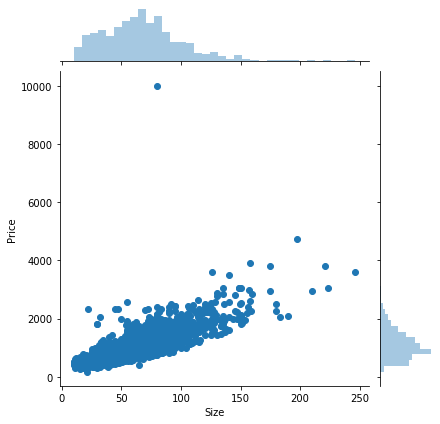

In [22]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

### Remove outliers

In [23]:
rental_properties = rental_properties[rental_properties['Price'] <= 3200]

In [24]:
rental_properties = rental_properties[rental_properties['Price/m2'] <= 200 ]

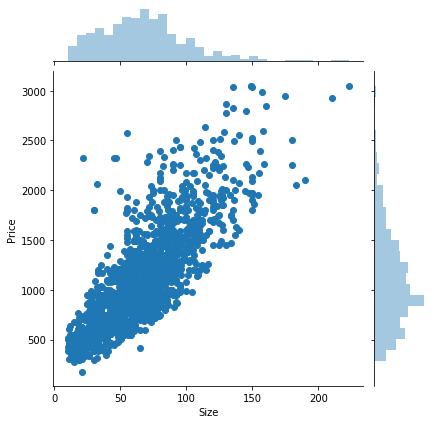

In [25]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

In [26]:
rental_properties.Size.max()

223.0

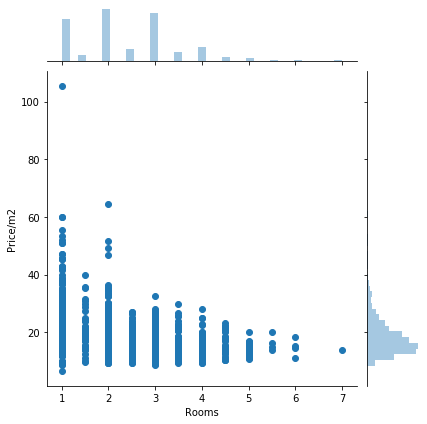

In [27]:
sns.jointplot(x='Rooms', y='Price/m2', data=rental_properties[['Rooms','Price/m2']])

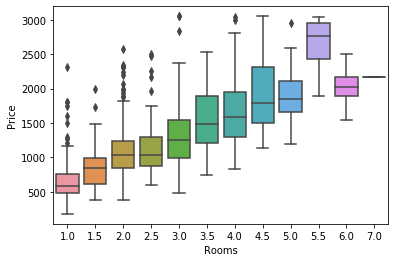

In [28]:
sns.boxplot(x='Rooms', y='Price', data=rental_properties)

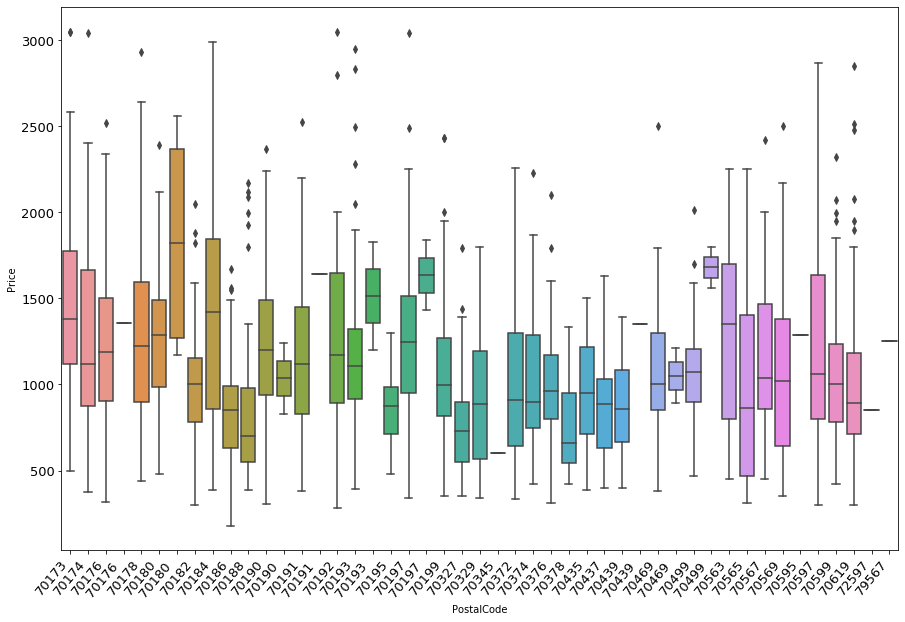

In [29]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='PostalCode', y='Price', data=rental_properties)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

In [30]:
stuttgart_districts = rental_properties[['District']].drop_duplicates().reset_index(drop=True)

In [31]:
stuttgart_districts['District']

0                 Ost
1             Münster
2       Bad Cannstatt
3           Neugereut
4                Nord
5                 Süd
6          Sillenbuch
7        Zuffenhausen
8                West
9           Degerloch
10              Mitte
11               Rohr
12         Mühlhausen
13          Feuerbach
14             Wangen
15       Obertürkheim
16          Rohracker
17          Stammheim
18      Untertürkheim
19          Vaihingen
20          Möhringen
21         Plieningen
22            Botnang
23           Freiberg
24         Luginsland
25        Hedelfingen
26            Birkach
27             Giebel
28         Weilimdorf
29          Lederberg
30          Kaltental
31           Heumaden
32           Asemwald
33         Riedenberg
34                Rot
35         Sonnenberg
36            Hoffeld
37            Uhlbach
38         Dürrlewang
39              Hofen
40          Steckfeld
41         Sommerrain
42             Hausen
43           Bergheim
44         Fasanenhof
45    Stei

In [32]:
latitude = np.zeros(stuttgart_districts.shape[0])
longitude = np.zeros(stuttgart_districts.shape[0])

geolocator = Nominatim(user_agent="stuttgart_districts")

for idx in range(stuttgart_districts.shape[0]):
    address = stuttgart_districts['District'].loc[idx] + ', Stuttgart'
    
    location = geolocator.geocode(address)
    latitude[idx] = location.latitude
    longitude[idx] = location.longitude
    #time.sleep(2)


In [33]:
district_coordinates = stuttgart_districts
district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates

District   Latitude  Longitude
0               Ost  48.799846   9.210061
1           Münster  48.821296   9.220002
2     Bad Cannstatt  48.804883   9.214680
3         Neugereut  48.833306   9.234239
4              Nord  48.800674   9.174650
5               Süd -26.903673 -49.091714
6        Sillenbuch  48.742184   9.222216
7      Zuffenhausen  48.831299   9.167440
8              West  48.778449   9.180013
9         Degerloch  48.749597   9.170345
10            Mitte  48.745383   9.103268
11             Rohr  48.717200   9.106000
12       Mühlhausen  48.845610   9.226179
13        Feuerbach  48.812305   9.159031
14           Wangen  48.771985   9.244927
15     Obertürkheim  48.764789   9.268515
16        Rohracker  48.756236   9.223561
17        Stammheim  48.849798   9.157305
18    Untertürkheim  48.780200   9.250900
19        Vaihingen  48.734429   9.088648
20        Möhringen  48.727816   9.147792
21       Plieningen  48.711395   9.198991
22          Botnang  48.778495   9.129532
23         Freiberg  48.836300   9.204900
24       Luginsland  48.793220   9.258251
25      Hedelfingen  48.756436   9.252665
26          Birkach  48.728574   9.203406
27           Giebel  48.804556   9.090039
28       Weilimdorf  48.815276   9.112444
29        Lederberg  48.752880   9.243529
30        Kaltental  48.738310   9.129363
31         Heumaden  48.747166   9.237747
32         Asemwald  48.725095   9.191837
33       Riedenberg  48.736000   9.213400
34              Rot  48.834100   9.192700
35       Sonnenberg  48.741583   9.152573
36          Hoffeld  48.735300   9.179500
37          Uhlbach  48.775844   9.280163
38       Dürrlewang  48.719615   9.118266
39            Hofen  48.834456   9.222368
40        Steckfeld  48.715300   9.201400
41       Sommerrain  48.815308   9.241017
42           Hausen  48.816454   9.086722
43         Bergheim  48.801300   9.089700
44       Fasanenhof  48.710468   9.157456
45  Steinhaldenfeld  48.827714   9.232018
46       Frauenkopf  48.760917   9.212772
47        Schönberg  48.732501   9.200140

In [34]:
#create map of Stuttgart using latitude and longitude values
map_stuttgart = folium.Map(location=[48.783333, 9.183333], zoom_start=11)

# add markers to map
for lat, lng, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stuttgart)  
    
map_stuttgart

### Visualize average price/m2 & avergage apartment size per district on a map

In [35]:
district_coordinates

District   Latitude  Longitude
0               Ost  48.799846   9.210061
1           Münster  48.821296   9.220002
2     Bad Cannstatt  48.804883   9.214680
3         Neugereut  48.833306   9.234239
4              Nord  48.800674   9.174650
5               Süd -26.903673 -49.091714
6        Sillenbuch  48.742184   9.222216
7      Zuffenhausen  48.831299   9.167440
8              West  48.778449   9.180013
9         Degerloch  48.749597   9.170345
10            Mitte  48.745383   9.103268
11             Rohr  48.717200   9.106000
12       Mühlhausen  48.845610   9.226179
13        Feuerbach  48.812305   9.159031
14           Wangen  48.771985   9.244927
15     Obertürkheim  48.764789   9.268515
16        Rohracker  48.756236   9.223561
17        Stammheim  48.849798   9.157305
18    Untertürkheim  48.780200   9.250900
19        Vaihingen  48.734429   9.088648
20        Möhringen  48.727816   9.147792
21       Plieningen  48.711395   9.198991
22          Botnang  48.778495   9.129532
23         Freiberg  48.836300   9.204900
24       Luginsland  48.793220   9.258251
25      Hedelfingen  48.756436   9.252665
26          Birkach  48.728574   9.203406
27           Giebel  48.804556   9.090039
28       Weilimdorf  48.815276   9.112444
29        Lederberg  48.752880   9.243529
30        Kaltental  48.738310   9.129363
31         Heumaden  48.747166   9.237747
32         Asemwald  48.725095   9.191837
33       Riedenberg  48.736000   9.213400
34              Rot  48.834100   9.192700
35       Sonnenberg  48.741583   9.152573
36          Hoffeld  48.735300   9.179500
37          Uhlbach  48.775844   9.280163
38       Dürrlewang  48.719615   9.118266
39            Hofen  48.834456   9.222368
40        Steckfeld  48.715300   9.201400
41       Sommerrain  48.815308   9.241017
42           Hausen  48.816454   9.086722
43         Bergheim  48.801300   9.089700
44       Fasanenhof  48.710468   9.157456
45  Steinhaldenfeld  48.827714   9.232018
46       Frauenkopf  48.760917   9.212772
47        Schönberg  48.732501   9.200140

In [36]:
Mean_per_district = rental_properties.groupby('District').mean()
Mean_per_district = Mean_per_district.reset_index()
Mean_per_district['Latitude'] = district_coordinates['Latitude'].drop_duplicates()
Mean_per_district['Longitude'] = district_coordinates['Longitude'].drop_duplicates()
Mean_per_district

District        Size     Rooms        Price   Price/m2   Latitude  \
0          Asemwald   56.500000  1.625000  1057.500000  20.521133  48.799846   
1     Bad Cannstatt   69.020000  2.586420  1059.918148  16.316346  48.821296   
2          Bergheim   73.000000  3.000000  1046.666667  14.323916  48.804883   
3           Birkach   58.526667  2.333333   969.666667  17.675036  48.833306   
4           Botnang   64.244667  2.433333   884.000000  14.658370  48.800674   
5         Degerloch   66.669333  2.483333  1222.500000  18.307284 -26.903673   
6        Dürrlewang   54.750000  2.625000   917.500000  17.197978  48.742184   
7        Fasanenhof   58.666667  2.250000  1150.833333  19.709698  48.831299   
8         Feuerbach   67.943188  2.347826  1106.038986  17.755103  48.778449   
9        Frauenkopf   92.212500  3.125000  1602.500000  18.619320  48.749597   
10         Freiberg   63.093333  2.500000   786.201667  14.282158  48.745383   
11           Giebel   91.590000  3.166667  1266.740000  13.459303  48.717200   
12           Hausen  105.000000  4.500000  1400.000000  13.333333  48.845610   
13      Hedelfingen   56.772000  2.225000   873.450000  18.391358  48.812305   
14         Heumaden   84.700000  2.868421  1253.947368  14.812612  48.771985   
15            Hofen   43.600000  1.722222   737.222222  20.386505  48.764789   
16          Hoffeld   51.857143  1.714286   917.142857  20.808231  48.756236   
17        Kaltental   64.792727  2.590909  1057.272727  16.845235  48.849798   
18        Lederberg   61.720000  1.750000   680.500000  11.046223  48.780200   
19       Luginsland   61.000000  2.500000   650.000000  10.655738  48.734429   
20            Mitte   69.666908  2.335526  1311.153816  21.456970  48.727816   
21        Möhringen   64.723279  2.442623  1166.631475  19.040602  48.711395   
22       Mühlhausen   74.333333  2.666667   870.000000  11.476367  48.778495   
23          Münster   58.612500  2.437500   748.952500  12.840399  48.836300   
24        Neugereut   64.681250  2.187500   731.048750  11.213946  48.793220   
25             Nord   69.428394  2.200730  1259.599124  19.315097  48.756436   
26     Obertürkheim   64.277778  2.555556   911.111111  15.141088  48.728574   
27              Ost   60.965789  2.302632  1007.952237  19.360657  48.804556   
28       Plieningen   64.382500  2.446429  1015.857143  16.667370  48.815276   
29       Riedenberg   64.817143  2.250000   973.928571  15.807644  48.752880   
30             Rohr   70.111111  2.555556  1198.888889  17.011648  48.738310   
31        Rohracker   74.166667  2.833333   878.333333  13.229752  48.747166   
32              Rot   69.982857  2.500000   982.000000  14.797676  48.725095   
33        Schönberg   90.333333  2.666667  1790.000000  19.772257  48.736000   
34       Sillenbuch   62.111111  2.055556   952.333333  14.891997  48.834100   
35       Sommerrain   56.202500  2.125000   958.250000  19.132797  48.741583   
36       Sonnenberg   97.000000  3.055556  1581.111111  16.228232  48.735300   
37        Stammheim   68.988333  2.527778   931.761111  13.750120  48.775844   
38        Steckfeld   52.800000  2.200000   956.000000  19.176446  48.719615   
39  Steinhaldenfeld   35.000000  2.000000   550.000000  15.714286  48.834456   
40              Süd   70.571923  2.534615  1252.202462  18.638287  48.715300   
41          Uhlbach   65.241667  2.583333   880.000000  13.490806  48.815308   
42    Untertürkheim   47.082609  1.760870   689.695652  20.235551  48.816454   
43        Vaihingen   63.368611  2.222222  1126.458333  18.947931  48.801300   
44           Wangen   61.655556  2.305556   930.833333  16.180847  48.710468   
45       Weilimdorf   72.700000  2.640000  1121.280000  16.069819  48.827714   
46             West   67.146886  2.410088  1219.362544  20.118214  48.760917   
47     Zuffenhausen   59.238605  2.406977   943.976744  17.246714  48.732501   

    Longitude  
0    9.210061  
1    9.220002  
2    9.214680  
3    9.234239  
4    9.174

In [37]:
#create map of Stuttgart using latitude and longitude values
map_stuttgart = folium.Map(location=[48.783333, 9.183333], zoom_start=11)

# add markers to map
for lat, lng, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stuttgart)  
    
map_stuttgart

### Average apartment size per district

In [38]:
districts_geo = r'out-2.json'

with open(districts_geo) as district_file:
    districts_geo_json = json.load(district_file)

districts_geo_json 


{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'layer': 'A62',
    'DISTRICT': 'West',
    'type': 'LWPOLYLINE',
    'source': 'Stadtbezirke.dxf'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[9.100559240517612, 48.79877560824383],
      [9.1004184928791, 48.79900519858364],
      [9.100198740668702, 48.79890767747972],
      [9.099908349075207, 48.7987515558639],
      [9.099611982355867, 48.79859858244808],
      [9.099250685826263, 48.798500710702],
      [9.09882074163636, 48.798387182733336],
      [9.098776260075198, 48.798444384073434],
      [9.098646400454783, 48.798443421971854],
      [9.098560624076214, 48.79832036030305],
      [9.098156704921024, 48.79823639480938],
      [9.09792885307479, 48.798173070744696],
      [9.09771547435173, 48.79806478990264],
      [9.097577116776222, 48.79797356442785],
      [9.097433713521553, 48.79779163776189],
      [9.097369580391955, 48.79766988646793],
      [9.097356302310914, 48.797547

In [39]:
stuttgart_geo = districts_geo_json

# create a plain map of Stuttgart
stuttgart_map = folium.Map(location=[48.783333, 9.183333], zoom_start=11)

# add the data
choropleth=folium.Choropleth(
    geo_data=stuttgart_geo,
    data=Mean_per_district,
    columns=['District', 'Size'],
    key_on='properties.DISTRICT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.7,
    highlight=True,
    legend_name='Average apartment size for each district in Stuttgart'
).add_to(stuttgart_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['DISTRICT'])
)

# add markers to map
#for lat, lng, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['District']):
#    dist = postalcode[1:3]
#    label = '{}. {}'.format(dist, district)
#    label = folium.Popup(label, parse_html=True)
#    folium.Circle(
#        [lat, lng],
#        radius=100,
#        popup=label,
#        color='blue',
#        fill=True,
#        fill_color='#3186cc',
#        fill_opacity=0.7,
#        parse_html=False).add_to(stuttgart_map) 



stuttgart_map


### Average apartment Price/m2 per district

In [40]:
stuttgart_geo = districts_geo_json

# create a plain map of Stuttgart
stuttgart_map = folium.Map(location=[48.783333, 9.183333], zoom_start=11)

# add the data
choropleth=folium.Choropleth(
    geo_data=stuttgart_geo,
    data=Mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='properties.DISTRICT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.7,
    highlight=True,
    legend_name='Average apartment Price/m2 for each district in Stuttgart'
).add_to(stuttgart_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['DISTRICT'])
)

# add markers to map
#for lat, lng, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['District']):
#    dist = postalcode[1:3]
#    label = '{}. {}'.format(dist, district)
#    label = folium.Popup(label, parse_html=True)
#    folium.Circle(
#        [lat, lng],
#        radius=100,
#        popup=label,
#        color='blue',
#        fill=True,
#        fill_color='#3186cc',
#        fill_opacity=0.7,
#        parse_html=False).add_to(stuttgart_map) 



stuttgart_map



## get venues for each district in Stuttgart

In [1]:
# The code was removed by Watson Studio for sharing.

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
stuttgart_venues = getNearbyVenues(names=district_coordinates['District'],
                                   latitudes=district_coordinates['Latitude'],
                                   longitudes=district_coordinates['Longitude'],
                                   radius=2000, LIMIT=100)
stuttgart_venues.head()

District  District Latitude  District Longitude  \
0      Ost          48.799846            9.210061   
1      Ost          48.799846            9.210061   
2      Ost          48.799846            9.210061   
3      Ost          48.799846            9.210061   
4      Ost          48.799846            9.210061   

                               Venue  Venue Latitude  Venue Longitude  \
0                   Mineralbad Leuze       48.798667         9.210122   
1  Motel One Stuttgart-Bad Cannstatt       48.803450         9.214496   
2           Gewächshäuser | Wilhelma       48.804081         9.207995   
3                     Rosensteinpark       48.804051         9.200159   
4                         buschpilot       48.793884         9.206151   

     Venue Category  
0              Pool  
1             Hotel  
2  Botanical Garden  
3              Park  
4               Bar

In [44]:
print('{} venues are collected'.format(stuttgart_venues.shape[0]))
print('There are {} uniques categories.'.format(len(stuttgart_venues['Venue Category'].unique())))

2081 venues are collected
There are 213 uniques categories.


In [45]:
stuttgart_venues.groupby('District')['Venue'].count()

District
Asemwald            13
Bad Cannstatt      100
Bergheim            17
Birkach             16
Botnang             47
Degerloch           96
Dürrlewang          62
Fasanenhof          69
Feuerbach           66
Frauenkopf          28
Freiberg            30
Giebel              22
Hausen              40
Hedelfingen         27
Heumaden            21
Hofen               34
Hoffeld             53
Kaltental           74
Lederberg           18
Luginsland          31
Mitte               49
Möhringen           60
Mühlhausen          17
Münster             67
Neugereut           27
Nord                84
Obertürkheim        32
Ost                100
Plieningen          17
Riedenberg          12
Rohr                52
Rohracker           16
Rot                 43
Schönberg           13
Sillenbuch          14
Sommerrain          32
Sonnenberg          45
Stammheim           37
Steckfeld           21
Steinhaldenfeld     27
Süd                100
Uhlbach             23
Untertürkheim       50
Va

In [46]:
# one hot encoding
stuttgart_onehot = pd.get_dummies(stuttgart_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stuttgart_onehot['District'] = stuttgart_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [stuttgart_onehot.columns[-1]] + list(stuttgart_onehot.columns[:-1])
stuttgart_onehot = stuttgart_onehot[fixed_columns]

stuttgart_onehot.head()

District  African Restaurant  Airport Service  American Restaurant  \
0      Ost                   0                0                    0   
1      Ost                   0                0                    0   
2      Ost                   0                0                    0   
3      Ost                   0                0                    0   
4      Ost                   0                0                    0   

   Aquarium  Art Museum  Asian Restaurant  Athletics & Sports  \
0         0           0                 0                   0   
1         0           0                 0                   0   
2         0           0                 0                   0   
3         0           0                 0                   0   
4         0           0                 0                   0   

   Auto Dealership  Auto Workshop  ...  Vietnamese Restaurant  Vineyard  \
0                0              0  ...                      0         0   
1                0              0  ...                      0         0   
2                0              0  ...                      0         0   
3                0              0  ...                      0         0   
4                0              0  ...                      0         0   

   Warehouse Store  Wine Bar  Wine Shop  Winery  Wings Joint  Yoga Studio  \
0                0         0          0       0            0            0   
1                0         0          0       0            0            0   
2                0         0          0       0            0            0   
3                0         0          0       0            0            0   
4                0         0          0       0            0            0   

   Zoo  Zoo Exhibit  
0    0            0  
1    0            0  
2    0            0  
3    0            0  
4    0            0  

[5 rows x 214 columns]

In [47]:
stuttgart_grouped = stuttgart_onehot.groupby('District').mean().reset_index()
stuttgart_grouped


District  African Restaurant  Airport Service  American Restaurant  \
0          Asemwald            0.000000         0.076923             0.000000   
1     Bad Cannstatt            0.000000         0.000000             0.000000   
2          Bergheim            0.000000         0.000000             0.000000   
3           Birkach            0.000000         0.000000             0.000000   
4           Botnang            0.000000         0.000000             0.000000   
5         Degerloch            0.020833         0.000000             0.020833   
6        Dürrlewang            0.000000         0.000000             0.000000   
7        Fasanenhof            0.000000         0.000000             0.000000   
8         Feuerbach            0.000000         0.000000             0.000000   
9        Frauenkopf            0.000000         0.000000             0.000000   
10         Freiberg            0.000000         0.000000             0.000000   
11           Giebel            0.000000         0.000000             0.000000   
12           Hausen            0.000000         0.000000             0.000000   
13      Hedelfingen            0.000000         0.000000             0.000000   
14         Heumaden            0.000000         0.000000             0.000000   
15            Hofen            0.000000         0.000000             0.000000   
16          Hoffeld            0.000000         0.000000             0.018868   
17        Kaltental            0.013514         0.000000             0.000000   
18        Lederberg            0.000000         0.000000             0.000000   
19       Luginsland            0.000000         0.000000             0.000000   
20            Mitte            0.000000         0.000000             0.000000   
21        Möhringen            0.016667         0.000000             0.000000   
22       Mühlhausen            0.000000         0.000000             0.000000   
23          Münster            0.000000         0.000000             0.000000   
24        Neugereut            0.000000         0.000000             0.000000   
25             Nord            0.000000         0.000000             0.000000   
26     Obertürkheim            0.000000         0.000000             0.000000   
27              Ost            0.000000         0.000000             0.000000   
28       Plieningen            0.000000         0.000000             0.000000   
29       Riedenberg            0.000000         0.000000             0.000000   
30             Rohr            0.000000         0.000000             0.000000   
31        Rohracker            0.000000         0.000000             0.000000   
32              Rot            0.000000         0.000000             0.000000   
33        Schönberg            0.000000         0.000000             0.000000   
34       Sillenbuch            0.000000         0.000000             0.000000   
35       Sommerrain            0.000000         0.000000             0.000000   
36       Sonnenberg            0.022222         0.000000             0.022222   
37        Stammheim            0.000000         0.000000             0.000000   
38        Steckfeld            0.000000         0.000000             0.000000   
39  Steinhaldenfeld            0.000000         0.000000             0.000000   
40              Süd            0.000000         0.000000             0.010000   
41          Uhlbach            0.000000         0.000000             0.000000   
42    Untertürkheim            0.000000         0.000000             0.000000   
43        Vaihingen            0.000000         0.000000             0.000000   
44           Wangen            0.000000         0.000000             0.000000   
45       Weilimdorf            0.000000         0.000000             0.000000   
46             West            0.020000         0.000000             0.000000   
47     Zuffenhausen            0.000000         0.000000             0.000000   

    Aquarium  Art Museum  Asian Restauran

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = stuttgart_grouped['District']

for idx in np.arange(stuttgart_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(stuttgart_grouped.iloc[idx, :], num_top_venues)

In [50]:
district_venues_sorted

District 1st Most Common Venue 2nd Most Common Venue  \
0          Asemwald              Bus Stop                 Hotel   
1     Bad Cannstatt                  Café           Supermarket   
2          Bergheim           Supermarket                 Hotel   
3           Birkach    Italian Restaurant              Bus Stop   
4           Botnang           Supermarket    Italian Restaurant   
5         Degerloch                  Café     German Restaurant   
6        Dürrlewang     German Restaurant                 Hotel   
7        Fasanenhof                 Hotel           Supermarket   
8         Feuerbach         Metro Station    Italian Restaurant   
9        Frauenkopf     German Restaurant    Italian Restaurant   
10         Freiberg         Metro Station  Gym / Fitness Center   
11           Giebel           Supermarket                 Hotel   
12           Hausen                Bakery           Supermarket   
13      Hedelfingen           Supermarket    Light Rail Station   
14         Heumaden    Italian Restaurant           Supermarket   
15            Hofen         Metro Station     German Restaurant   
16          Hoffeld     German Restaurant                 Hotel   
17        Kaltental     German Restaurant         Metro Station   
18        Lederberg           Supermarket           Bus Station   
19       Luginsland     German Restaurant               Stadium   
20            Mitte     German Restaurant             Gastropub   
21        Möhringen     German Restaurant         Metro Station   
22       Mühlhausen         Metro Station     German Restaurant   
23          Münster     German Restaurant         Metro Station   
24        Neugereut         Metro Station    Italian Restaurant   
25             Nord            Restaurant    Italian Restaurant   
26     Obertürkheim           Supermarket                 Hotel   
27              Ost                  Café           Supermarket   
28       Plieningen                 Hotel    Italian Restaurant   
29       Riedenberg    Italian Restaurant                Bakery   
30             Rohr                Bakery     German Restaurant   
31        Rohracker         Metro Station    Italian Restaurant   
32              Rot         Metro Station     German Restaurant   
33        Schönberg              Bus Stop    Italian Restaurant   
34       Sillenbuch    Italian Restaurant           Supermarket   
35       Sommerrain           Supermarket         Metro Station   
36       Sonnenberg           Supermarket         Metro Station   
37        Stammheim                 Hotel    Italian Restaurant   
38        Steckfeld                 Hotel    Italian Restaurant   
39  Steinhaldenfeld           Supermarket     German Restaurant   
40              Süd  Gym / Fitness Center                Bakery   
41          Uhlbach     German Restaurant           Bus Station   
42    Untertürkheim     German Restaurant           Supermarket   
43        Vaihingen                Bakery      Asian Restaurant   
44           Wangen           Supermarket     German Restaurant   
45       Weilimdorf           Supermarket    Italian Restaurant   
46             West                  Café    Italian Restaurant   
47     Zuffenhausen                 Hotel    Turkish Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0        Airport Service           Sports Club            Playground   
1            Zoo Exhibit                  Park                 Hotel   
2                  Plaza                Bakery          Soccer Field   
3                   Café     German Restaurant                   Gym   
4           Dessert Shop     German Restaurant                Bakery   
5            Supermarket            Restaurant                   Bar   
6                 Bakery      Asian Restaurant           Supermarket   
7                    Gym    Chinese Restaurant             Drugstore   
8     Turkish Restaurant            Restaurant     German Restaurant   
9      

# Cluster Districts

### Run k-means to cluster the districts into 2 clusters (in this case the best k is 2)


In [51]:
# set number of clusters
kclusters = 2

stuttgart_grouped_clustering = stuttgart_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stuttgart_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]
district_venues_sorted

District 1st Most Common Venue 2nd Most Common Venue  \
0          Asemwald              Bus Stop                 Hotel   
1     Bad Cannstatt                  Café           Supermarket   
2          Bergheim           Supermarket                 Hotel   
3           Birkach    Italian Restaurant              Bus Stop   
4           Botnang           Supermarket    Italian Restaurant   
5         Degerloch                  Café     German Restaurant   
6        Dürrlewang     German Restaurant                 Hotel   
7        Fasanenhof                 Hotel           Supermarket   
8         Feuerbach         Metro Station    Italian Restaurant   
9        Frauenkopf     German Restaurant    Italian Restaurant   
10         Freiberg         Metro Station  Gym / Fitness Center   
11           Giebel           Supermarket                 Hotel   
12           Hausen                Bakery           Supermarket   
13      Hedelfingen           Supermarket    Light Rail Station   
14         Heumaden    Italian Restaurant           Supermarket   
15            Hofen         Metro Station     German Restaurant   
16          Hoffeld     German Restaurant                 Hotel   
17        Kaltental     German Restaurant         Metro Station   
18        Lederberg           Supermarket           Bus Station   
19       Luginsland     German Restaurant               Stadium   
20            Mitte     German Restaurant             Gastropub   
21        Möhringen     German Restaurant         Metro Station   
22       Mühlhausen         Metro Station     German Restaurant   
23          Münster     German Restaurant         Metro Station   
24        Neugereut         Metro Station    Italian Restaurant   
25             Nord            Restaurant    Italian Restaurant   
26     Obertürkheim           Supermarket                 Hotel   
27              Ost                  Café           Supermarket   
28       Plieningen                 Hotel    Italian Restaurant   
29       Riedenberg    Italian Restaurant                Bakery   
30             Rohr                Bakery     German Restaurant   
31        Rohracker         Metro Station    Italian Restaurant   
32              Rot         Metro Station     German Restaurant   
33        Schönberg              Bus Stop    Italian Restaurant   
34       Sillenbuch    Italian Restaurant           Supermarket   
35       Sommerrain           Supermarket         Metro Station   
36       Sonnenberg           Supermarket         Metro Station   
37        Stammheim                 Hotel    Italian Restaurant   
38        Steckfeld                 Hotel    Italian Restaurant   
39  Steinhaldenfeld           Supermarket     German Restaurant   
40              Süd  Gym / Fitness Center                Bakery   
41          Uhlbach     German Restaurant           Bus Station   
42    Untertürkheim     German Restaurant           Supermarket   
43        Vaihingen                Bakery      Asian Restaurant   
44           Wangen           Supermarket     German Restaurant   
45       Weilimdorf           Supermarket    Italian Restaurant   
46             West                  Café    Italian Restaurant   
47     Zuffenhausen                 Hotel    Turkish Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0        Airport Service           Sports Club            Playground   
1            Zoo Exhibit                  Park                 Hotel   
2                  Plaza                Bakery          Soccer Field   
3                   Café     German Restaurant                   Gym   
4           Dessert Shop     German Restaurant                Bakery   
5            Supermarket            Restaurant                   Bar   
6                 Bakery      Asian Restaurant           Supermarket   
7                    Gym    Chinese Restaurant             Drugstore   
8     Turkish Restaurant            Restaurant     German Restaurant   
9      

### Let's create a new dataframe that includes the cluster as well as the price/m2 and the top 10 venues for each neighborhood.

In [52]:
# add clustering labels
district_venues_sorted.insert(0,'Cluster Labels',  kmeans.labels_)
# add price/m2 for each district
stuttgart_merged = pd.merge(district_coordinates, Mean_per_district[['District', 'Price/m2']])

# add latitude/longitude for each district
stuttgart_merged = stuttgart_merged.join(district_venues_sorted.set_index('District'), on='District')

stuttgart_merged.head()

District   Latitude  Longitude   Price/m2  Cluster Labels  \
0            Ost  48.799846   9.210061  19.360657               0   
1        Münster  48.821296   9.220002  12.840399               0   
2  Bad Cannstatt  48.804883   9.214680  16.316346               0   
3      Neugereut  48.833306   9.234239  11.213946               1   
4           Nord  48.800674   9.174650  19.315097               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Café           Supermarket                  Park   
1     German Restaurant         Metro Station           Supermarket   
2                  Café           Supermarket           Zoo Exhibit   
3         Metro Station    Italian Restaurant     German Restaurant   
4            Restaurant    Italian Restaurant                  Park   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0             Drugstore                 Hotel     German Restaurant   
1           Zoo Exhibit                  Café      Greek Restaurant   
2                  Park                 Hotel     German Restaurant   
3           Supermarket  Gym / Fitness Center      Greek Restaurant   
4                 Hotel           Beer Garden    Turkish Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Zoo Exhibit          Concert Hall       Thai Restaurant   
1                 Hotel               Theater      Asian Restaurant   
2                  Pool            Restaurant         Metro Station   
3                Bakery           Gas Station            Playground   
4                Bakery         Shopping Mall       Organic Grocery   

  10th Most Common Venue  
0                    Bar  
1            Beer Garden  
2                    Bar  
3          Big Box Store  
4              Nightclub

In [53]:
stuttgart_merged['Cluster Labels'].value_counts()

0    35
1    13
Name: Cluster Labels, dtype: int64

In [54]:
# create map
map_clusters = folium.Map(location=[48.783333, 9.183333], zoom_start=11)

# set colors
rainbow = ['blue', 'red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stuttgart_merged['Latitude'], stuttgart_merged['Longitude'], stuttgart_merged['District'], stuttgart_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
stuttgart_grouped.insert(0,'Cluster Labels',  kmeans.labels_)

In [56]:
stuttgart_merged.groupby('Cluster Labels').max()

District   Latitude  Longitude   Price/m2  \
Cluster Labels                                                     
0                  Zuffenhausen  48.849798   9.280163  21.456970   
1               Steinhaldenfeld  48.845610   9.243529  20.386505   

               1st Most Common Venue 2nd Most Common Venue  \
Cluster Labels                                               
0                        Supermarket    Turkish Restaurant   
1                        Supermarket           Supermarket   

               3rd Most Common Venue 4th Most Common Venue  \
Cluster Labels                                               
0                        Zoo Exhibit           Zoo Exhibit   
1                        Supermarket         Train Station   

               5th Most Common Venue 6th Most Common Venue  \
Cluster Labels                                               
0                        Supermarket    Turkish Restaurant   
1                              Trail          Soccer Field   

               7th Most Common Venue 8th Most Common Venue  \
Cluster Labels                                               
0                        Zoo Exhibit               Theater   
1                                Spa          Soccer Field   

               9th Most Common Venue 10th Most Common Venue  
Cluster Labels                                               
0                            Theater                Taverna  
1                            Taverna          Shopping Mall

By analyzing the clusters we can see that cluster 1 is more central and more commercial/touristic with restaurants, theaters, Zoos, etc. while cluster 0 is more decentral and residental with metro stations, supermarkets, and soccer fields.

# Final Visualization
### With all the gathered data we can now create a choropleth map displaying the average price/m2 for each district as well as display information about the area type and top 10 locations for each district on the marker labels. With this map, one could determine for example that the district "Altstadt" is the most expensive district to live in, however by clustering we determined that there are several more similar districts where the price/m2 is significantly lower. Therefore, if someone wants to rent an apartment but cannot afford to live in the district " Altstadt", they could look for apartments in Longerich or Raderthal which is similar in venues but has much lower price for renting apartments.

In [57]:
stuttgart_map = folium.Map(location=[48.783333, 9.183333], zoom_start=11)

# add the data
stuttgart_map.choropleth(
    geo_data=stuttgart_geo,
    data=Mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='properties.DISTRICT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in stuttgart'
)


# set colors
marker_colors = ['blue', 'red']

# add markers for e
for idx in range(len(stuttgart_merged)):
    html_label = ''
    
    lat = stuttgart_merged['Latitude'].loc[idx]
    lng = stuttgart_merged['Longitude'].loc[idx]
    cluster = stuttgart_merged['Cluster Labels'].loc[idx]
    average_price = stuttgart_merged['Price/m2'].loc[idx]
    
    if (cluster == 0):
        area = 'Residential'
    elif (cluster == 1):
        area = 'Commercial / Touristic'
    else: area = "NA"
    
    html_label = '<h4>' + district + '</h4><h5><b> Area: </b>' + area + '</h5><h5><b> Average Price/m2: </b>' + str(average_price.round(2)) + '€ </h5><h5><b> Top 10 Venues: </b></h5><h5><ol>'
    
    for col in range(5, 15):
        html_label += '<li>' + stuttgart_merged.iloc[idx, col]
    html_label += '</ol></h5>'
       
  
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=html_label,
        color=rainbow[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(stuttgart_map)


# display map
stuttgart_map

/Users/axelspahr/opt/anaconda3/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
